In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Configure paths (EDIT THE ZIP_PATH TO MATCH YOUR FILE ON DRIVE)

In [3]:
# 🔧 EDIT THIS to your actual folder that contains: std16k/  segments/  manifests/
# examples:
# DATA_ROOT = "/content/drive/MyDrive/audio_prepped"
# DATA_ROOT = "/content/drive/MyDrive/SafeVisionAI/audio/audio_prepped"
DATA_ROOT = "/content/drive/MyDrive/audio_prepped"  # <-- change to your folder

import os

print("DATA_ROOT:", DATA_ROOT)
print("Top-level:", os.listdir(DATA_ROOT))
print("Manifests:", os.listdir(os.path.join(DATA_ROOT, "manifests")))



DATA_ROOT: /content/drive/MyDrive/audio_prepped
Top-level: ['manifests', 'segments', 'std16k']
Manifests: ['files_manifest.csv', 'balanced_segments_manifest.csv', 'segments_manifest.csv']


In [4]:
!pip -q install tensorflow tensorflow-hub librosa soundfile scikit-learn joblib matplotlib pandas

In [5]:
import pandas as pd

USE_BALANCED = True  # switch to False if you prefer full manifest
MANIFEST = f"{DATA_ROOT}/manifests/" + ("balanced_segments_manifest.csv" if USE_BALANCED else "segments_manifest.csv")

df = pd.read_csv(MANIFEST)
print("Total rows:", len(df))
display(df.head())

print("\nCounts per split/label:")
display(df.groupby(["split","label"]).size().to_frame("count"))


Total rows: 16764


,split,label,audio_path,start_sec,duration_sec
0,train,violent,D:/SEM2/AML/SafeVisionAIML/Data/Audio/KaggleAu...,98.0,4.0
1,test,violent,D:/SEM2/AML/SafeVisionAIML/Data/Audio/KaggleAu...,1180.0,4.0
2,train,violent,D:/SEM2/AML/SafeVisionAIML/Data/Audio/KaggleAu...,674.0,4.0
3,train,non_violent,D:/SEM2/AML/SafeVisionAIML/Data/Audio/KaggleAu...,2142.0,4.0
4,train,violent,D:/SEM2/AML/SafeVisionAIML/Data/Audio/KaggleAu...,64.0,4.0



Counts per split/label:


count
split label             
test  non_violent   1563
      violent       1563
train non_violent   6819
      violent       6819

In [6]:
import os
from pathlib import Path

# 1) Normalize slashes
df["audio_path"] = df["audio_path"].str.replace("\\", "/", regex=False)

# 2) Rebase each row to your Drive dataset root:
#    Replace everything before "/segments/..." with f"{DATA_ROOT}/segments/..."
def rebase_to_drive(p: str) -> str:
    # keep the tail after the first "/segments/"
    if "/segments/" in p:
        tail = p.split("/segments/", 1)[1]  # e.g., "train/violent/foo.wav"
        return f"{DATA_ROOT}/segments/{tail}"
    # fallback: if the path already starts at segments, just prefix
    if p.startswith("segments/"):
        return f"{DATA_ROOT}/{p}"
    # last resort: just join to DATA_ROOT (may fail if structure differs)
    return f"{DATA_ROOT}/{Path(p).name}"

df["audio_path"] = df["audio_path"].apply(rebase_to_drive)

# 3) Drop rows whose files are missing (defensive)
df["exists"] = df["audio_path"].map(os.path.exists)
missing = df[~df["exists"]].copy()
if len(missing):
    print(f"Warning: {len(missing)} manifest rows point to missing files. Showing a few:")
    display(missing.head())
df = df[df["exists"]].drop(columns=["exists"]).reset_index(drop=True)

print("After rebase, counts per split/label:")
display(df.groupby(["split","label"]).size().to_frame("count"))


After rebase, counts per split/label:


count
split label             
test  non_violent   1563
      violent       1563
train non_violent   6819
      violent       6819

In [7]:
from sklearn.model_selection import train_test_split

n_val = (df["split"] == "val").sum()
if n_val == 0:
    print("No 'val' rows found — creating a stratified 10% validation split from 'train'.")
    df_train_only = df[df["split"] == "train"].copy()
    df_test_only  = df[df["split"] == "test"].copy()

    tr_idx, va_idx = train_test_split(
        df_train_only.index,
        test_size=0.10,
        stratify=df_train_only["label"],
        random_state=42
    )
    df_train_only.loc[:, "split"] = "train"
    df_train_only.loc[va_idx, "split"] = "val"

    df = pd.concat([df_train_only, df_test_only], ignore_index=True)
    print("New counts per split/label:")
    display(df.groupby(["split","label"]).size().to_frame("count"))
else:
    print(f"Found {n_val} validation rows — keeping existing splits.")


No 'val' rows found — creating a stratified 10% validation split from 'train'.
New counts per split/label:


count
split label             
test  non_violent   1563
      violent       1563
train non_violent   6137
      violent       6137
val   non_violent    682
      violent        682

4) Load YAMNet (TF-Hub) and embedding function

In [8]:
import tensorflow as tf, tensorflow_hub as hub, librosa, numpy as np

SR = 16000
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

def wav_to_yamnet_embedding(path, target_sr=SR):
    y, _ = librosa.load(path, sr=target_sr, mono=True)
    scores, embeddings, _ = yamnet(y)           # embeddings: [frames, 1024]
    e = tf.reduce_mean(embeddings, axis=0).numpy()  # [1024]
    return e

5) Build datasets with caching (fast re-runs)

In [9]:
import os, numpy as np
from pathlib import Path

df_train = df[df["split"] == "train"].reset_index(drop=True)
df_val   = df[df["split"] == "val"].reset_index(drop=True)
df_test  = df[df["split"] == "test"].reset_index(drop=True)

print("Rows per split:", {"train": len(df_train), "val": len(df_val), "test": len(df_test)})

CACHE_DIR = "/content/cache_yamnet"
os.makedirs(CACHE_DIR, exist_ok=True)
cache_stem = "balanced" if USE_BALANCED else "segments"

def build_split(df_split):
    X, y = [], []
    for r in df_split.itertuples(index=False):
        emb = wav_to_yamnet_embedding(r.audio_path)
        X.append(emb)
        y.append(0 if r.label == "non_violent" else 1)
    return np.stack(X), np.array(y)

def cache_or_build(split_name, df_split):
    npz = f"{CACHE_DIR}/{cache_stem}_{split_name}.npz"
    if os.path.exists(npz):
        d = np.load(npz)
        X, y = d["X"], d["y"]
        print(f"Loaded cache: {npz} shape={X.shape}")
    else:
        X, y = build_split(df_split)
        np.savez_compressed(npz, X=X, y=y)
        print(f"Wrote cache: {npz} shape={X.shape}")
    return X, y

Xtr, ytr = cache_or_build("train", df_train)
Xv,  yv  = cache_or_build("val",   df_val)
Xte, yte = cache_or_build("test",  df_test)

print("Shapes:", {"Xtr": Xtr.shape, "Xv": Xv.shape, "Xte": Xte.shape})


Rows per split: {'train': 12274, 'val': 1364, 'test': 3126}
Wrote cache: /content/cache_yamnet/balanced_train.npz shape=(12274, 1024)
Wrote cache: /content/cache_yamnet/balanced_val.npz shape=(1364, 1024)
Wrote cache: /content/cache_yamnet/balanced_test.npz shape=(3126, 1024)
Shapes: {'Xtr': (12274, 1024), 'Xv': (1364, 1024), 'Xte': (3126, 1024)}


6) Train classifier + validation report

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

CLASSES = ["non_violent", "violent"]

# scale
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xv_s  = scaler.transform(Xv)

# train LR head
clf = LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", C=1.0, random_state=42)
clf.fit(Xtr_s, ytr)

print("=== VALIDATION REPORT ===")
yvp = clf.predict(Xv_s)
print(classification_report(yv, yvp, target_names=CLASSES, digits=4))


=== VALIDATION REPORT ===
              precision    recall  f1-score   support

 non_violent     0.9926    0.9853    0.9890       682
     violent     0.9854    0.9927    0.9890       682

    accuracy                         0.9890      1364
   macro avg     0.9890    0.9890    0.9890      1364
weighted avg     0.9890    0.9890    0.9890      1364



7) Test metrics + confusion matrix

=== TEST REPORT ===
              precision    recall  f1-score   support

 non_violent     0.9409    0.4581    0.6162      1563
     violent     0.6419    0.9712    0.7729      1563

    accuracy                         0.7147      3126
   macro avg     0.7914    0.7147    0.6945      3126
weighted avg     0.7914    0.7147    0.6945      3126



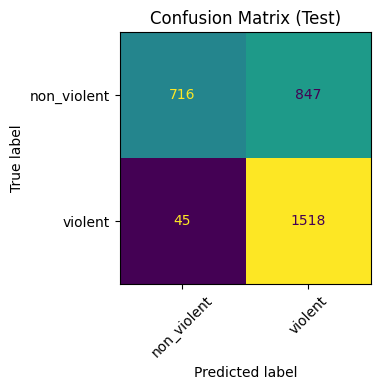

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Xte_s = scaler.transform(Xte)
ytep = clf.predict(Xte_s)

print("=== TEST REPORT ===")
print(classification_report(yte, ytep, target_names=CLASSES, digits=4))

cm = confusion_matrix(yte, ytep, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(4.5,4))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()


8) (optional) ROC-AUC figure

ROC-AUC (test): 0.8951


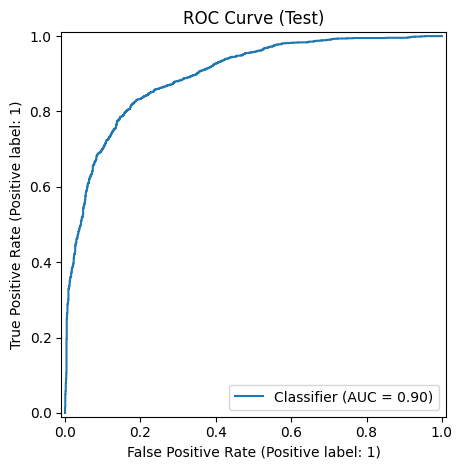

In [12]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

yte_proba = clf.predict_proba(Xte_s)[:, 1]
auc = roc_auc_score(yte, yte_proba)
print(f"ROC-AUC (test): {auc:.4f}")

RocCurveDisplay.from_predictions(yte, yte_proba)
plt.title("ROC Curve (Test)")
plt.tight_layout()
plt.show()


9) Save artifacts back to Drive

In [13]:
import os, shutil
from joblib import dump

# choose where to save on Drive:
ART_DIR_DRIVE = "/content/drive/MyDrive/audio_model_artifacts_yamnet"
ART_ZIP_DRIVE = "/content/drive/MyDrive/audio_model_artifacts_yamnet.zip"

os.makedirs(ART_DIR_DRIVE, exist_ok=True)
dump(scaler, f"{ART_DIR_DRIVE}/scaler.joblib")
dump(clf,    f"{ART_DIR_DRIVE}/head_lr.joblib")
with open(f"{ART_DIR_DRIVE}/classes.txt","w") as f:
    f.write("\n".join(CLASSES))

# zip bundle for easy download/use
if os.path.exists(ART_ZIP_DRIVE):
    os.remove(ART_ZIP_DRIVE)
shutil.make_archive(ART_ZIP_DRIVE.replace(".zip",""), "zip", ART_DIR_DRIVE)

print("✅ Saved artifacts to:", ART_DIR_DRIVE)
print("✅ Zipped bundle:", ART_ZIP_DRIVE)


✅ Saved artifacts to: /content/drive/MyDrive/audio_model_artifacts_yamnet
✅ Zipped bundle: /content/drive/MyDrive/audio_model_artifacts_yamnet.zip


10) Inference helper (load from Drive, quick test)

In [14]:
import joblib, tensorflow_hub as hub, tensorflow as tf, librosa, numpy as np

yamnet_inf = hub.load("https://tfhub.dev/google/yamnet/1")
scaler_inf = joblib.load(f"{ART_DIR_DRIVE}/scaler.joblib")
clf_inf    = joblib.load(f"{ART_DIR_DRIVE}/head_lr.joblib")
CLASSES_INF = open(f"{ART_DIR_DRIVE}/classes.txt").read().splitlines()

def predict_audio(path, target_sr=SR):
    y, _ = librosa.load(path, sr=target_sr, mono=True)
    scores, embeddings, _ = yamnet_inf(y)
    e = tf.reduce_mean(embeddings, axis=0).numpy().reshape(1, -1)
    e = scaler_inf.transform(e)
    proba = clf_inf.predict_proba(e)[0]
    idx = int(np.argmax(proba))
    return {"label": CLASSES_INF[idx],
            "score": float(proba[idx]),
            "probs": {CLASSES_INF[0]: float(proba[0]), CLASSES_INF[1]: float(proba[1])}}

# try one test file from the manifest
sample_path = df_test.iloc[0].audio_path
predict_audio(sample_path)


{'label': 'violent',
 'score': 0.9990537476738321,
 'probs': {'non_violent': 0.0009462523261678513,
  'violent': 0.9990537476738321}}